# Technical analysis

In [13]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

In [25]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

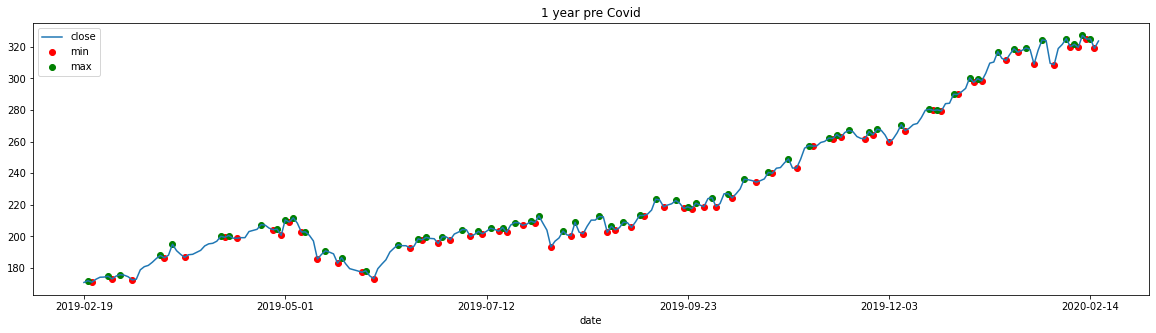

In [26]:
# companies = ['AAPL','FB','GOOG','F','TSLA']
companies = ['AAPL']
listofdf = []
for item in companies:
    histprices = requests.get(f"https://financialmodelingprep.com/api/v3/historical-price-full/{item}?serietype=line&from=2019-02-19&to=2020-02-19")
    histprices = histprices.json()

    #Parse the API response and select only last 600 days of prices
    #histprices = histprices['historical'][-600:]
    histprices = histprices['historical']
    #Convert from dict to pandas datafram
    histpricesdf = pd.DataFrame.from_dict(histprices)
    #rename column
    # histpricesdf = histpricesdf.rename({'close': item}, axis=1)
    #append all dfs to list
    listofdf.append(histpricesdf)
#set index of each DataFrame by common column before concatinating them
dfs = [df.set_index('date') for df in listofdf]
for df in dfs:
    df['min'] = df['close'][(df['close'].shift(1) > df['close']) & (df['close'].shift(-1) > df['close'])]
    df['max'] = df['close'][(df['close'].shift(1) < df['close']) & (df['close'].shift(-1) < df['close'])]
    
histpriceconcat = pd.concat(dfs,axis=1)
#set_trace()
#divide all dataframe by first line of data to enable comparison
#histpriceconcat = histpriceconcat/histpriceconcat.iloc[0]

#for i, col in enumerate(histpriceconcat.columns):
plt.title('1 year pre Covid')

histpriceconcat['close'].plot()

plt.scatter(histpriceconcat.index, histpriceconcat['min'], c='r')
plt.scatter(histpriceconcat.index, histpriceconcat['max'], c='g')

#plt.xticks(rotation=70)
plt.legend(histpriceconcat.columns)


In [24]:
plt.rcParams['figure.figsize']

[20.0, 5.0]